In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

#needed for jupyter notebook
#https://github.com/tensorflow/tensorflow/issues/24828
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Num GPUs Available:  3


In [2]:
# https://github.com/jkjung-avt/keras-cats-dogs-tutorial/blob/master/train_resnet50.py
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# resnet versions
# from tensorflow.keras.applications.resnet import ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input

# graph
import matplotlib.pyplot as plt

In [3]:
"""
hyperparameters + filenames
"""
DATASET_PATH = "may_split"
# DATASET_PATH = "exp_data"

# height = 2*width
# TARGET_SIZE = height, width 
# try reducing batch size or freeze more layers if your GPU runs out of memory

TARGET_SIZE = (224,112) 
BATCH_SIZE = 16
# BATCH_SIZE = 32  
# NUM_EPOCHS = 20
NUM_EPOCHS = 15
FREEZE_LAYERS = 101 # 2 + 3*33
# FREEZE_LAYERS = 35 # 2 + 3*11
# NUM_CLASSES defined later

print("BATCH_SIZE: ", BATCH_SIZE)
print("FREEZE_LAYERS: ", FREEZE_LAYERS)
print("NUM_EPOCHS: ", NUM_EPOCHS)
print("DATASET_PATH: ", DATASET_PATH)

BATCH_SIZE:  16
FREEZE_LAYERS:  101
NUM_EPOCHS:  2
DATASET_PATH:  3_15_split_2


In [4]:
"""
augmenting data
"""
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=0,
    shear_range=10,

    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.3,

    brightness_range=(0.8, 1.0),
    channel_shift_range=50.0,

    horizontal_flip=True,
)

# train_datagen.reset()

train_batches = train_datagen.flow_from_directory(
    DATASET_PATH + "/train",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
#     interpolation='bicubic',
    class_mode='categorical',
    shuffle=True)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# valid_datagen.reset()

valid_batches = valid_datagen.flow_from_directory(
    DATASET_PATH + "/valid",
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE,
#     interpolation='bicubic',
    class_mode='categorical',
    shuffle=True)

NUM_CLASSES = len(train_batches.class_indices.items())

Found 17406 images belonging to 13 classes.
Found 4345 images belonging to 13 classes.


In [5]:
"""
training nnet
"""


# https://github.com/jkjung-avt/keras-cats-dogs-tutorial/blob/master/train_resnet50.py

#train net
# build our classifier model based on pre-trained ResNet50:
# 1. we don't include the top (fully connected) layers of ResNet50
# 2. we add a DropOut layer followed by a Dense (fully connected)
#    layer which generates softmax class score for each class
# 3. we compile the final model using an Adam optimizer, with a
#    low learning rate (since we are 'fine-tuning')
net = ResNet152V2(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(TARGET_SIZE[0],TARGET_SIZE[1],3))
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)
net_final = Model(inputs=net.input, outputs=output_layer)


"""
#continue training old model
import os
from tensorflow.keras.models import load_model

MODEL_PATH = "saved_models"
net_file = "new_allclass_9801_1583419590_highangle_RES152V2.h5"
net_path = os.path.join(MODEL_PATH, net_file)
net_final = load_model(net_path)
print("Loaded:", net_path)
"""

#freeze layers
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

net_final.compile(optimizer=Adam(lr=1e-5, beta_1=0.99),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# print(net_final.summary())

# train the model
history = net_final.fit(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 271 steps
Epoch 1/2
1087/1087 [==============================] - 162s 149ms/step - loss: 1.2293 - accuracy: 0.6796 - val_loss: 0.2974 - val_accuracy: 0.9008
Epoch 2/2
1087/1087 [==============================] - 147s 135ms/step - loss: 0.3002 - accuracy: 0.9083 - val_loss: 0.1136 - val_accuracy: 0.9670


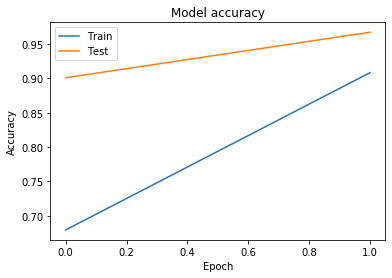

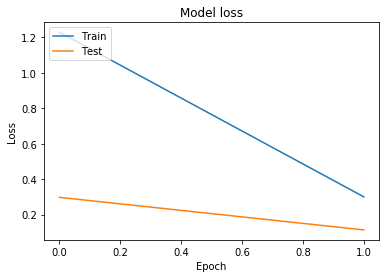

In [10]:
# plot acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time, os
from tensorflow.keras.preprocessing import image

IMG_DIR = os.path.join(DATASET_PATH,"valid")
ALL_CLASSES = sorted(os.listdir(os.path.join(DATASET_PATH,"valid")))

imgs = []
classes = []
for cls in ALL_CLASSES: #class is Python keyword
    print("-"*5,cls,"-"*5,"\n")
    CLASS_DIR = os.path.join(IMG_DIR, cls)
    for filename in os.listdir(CLASS_DIR):
        img_path = os.path.join(CLASS_DIR, filename)

        img = image.load_img(img_path, target_size=TARGET_SIZE)
        if not img: continue
        x = image.img_to_array(img)
        x = preprocess_input(x)
#         x = np.expand_dims(x, axis=0) #need to add dim to put into resnet

        imgs.append(x)
        classes.append(ALL_CLASSES.index(cls))
#         print(len(imgs))

imgs = np.asarray(imgs)
classes = np.asarray(classes)

print(imgs.shape)
print(classes.shape)
# print(classes)
Y_pred = net_final.predict(imgs)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
print('Confusion Matrix')
print(confusion_matrix(classes, y_pred))

----- black_bishop ----- 

----- black_king ----- 

----- black_knight ----- 

----- black_pawn ----- 

----- black_queen ----- 

----- black_rook ----- 

----- empty ----- 

----- white_bishop ----- 

----- white_king ----- 

----- white_knight ----- 

----- white_pawn ----- 

----- white_queen ----- 

----- white_rook ----- 

(4345, 224, 112, 3)
(4345,)
[ 0  0  0 ... 12 12 12]
Confusion Matrix
[[ 129    0    8    8    4    1    2    0    0    0    0    0    0]
 [   3  136    0    1    0    0    3    1    0    0    0    1    0]
 [   5    1   99    8    0    2    1    0    0    0    0    0    0]
 [   0    0    3  732    1    0    2    0    0    0    2    0    0]
 [   2    3    2    0   90    6    0    0    0    0    0    1    0]
 [   0    1    0    1    1  162    2    0    0    0    0    0    0]
 [   0    0    1    5    0    0 1466    2    0    1    4    0    0]
 [   0    0    0    0    0    0    0  138    2    0    6    0    0]
 [   0    1    0    0    0    0    1    1  143    0    0 

In [9]:
"""
fill this in
"""

import os
MODELS_PATH = "saved_models"
if not os.path.exists(MODELS_PATH):
    os.mkdir(MODELS_PATH)

# get current date and time
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%m.%d-%H:%M:%S") #month.day-hr:min:sec
print("Timestamp:", dt_string)
    
model_filename = "50cs_{}_{}_RES152V2.h5".format(DATASET_PATH, dt_string)
filepath = os.path.join(MODELS_PATH, model_filename)
net_final.save(filepath)
print("Model saved at:", filepath)

Timestamp: 03.20-15:29:04
Model saved at: saved_models/50cs_3_15_split_2_03.20-15:29:04_RES152V2.h5


In [ ]:
"""
separate weights and model saving
"""
net_final.save_weights("123weights.h5")
model_json = net_final.to_json()
with open('123model.json', 'w') as json_file:
    json_file.write(model_json)
json_file.close()